In [1]:

import configparser
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from binance.client import Client

In [2]:
CFG_FL_NAME = "../user.cfg"
USER_CFG_SECTION = "binance_user_config"
config = configparser.ConfigParser()
config.read(CFG_FL_NAME)

api_key = config.get(USER_CFG_SECTION, "api_key")
api_secret = config.get(USER_CFG_SECTION, "api_secret_key")
client = Client(api_key, api_secret)

In [3]:
def get_ticker_price(ticker_symbol: str, days:int ):
    """
    Get ticker price of a specific coin
    """

    target_date = (datetime.now() -timedelta(days = days)).strftime("%d %b %Y %H:%M:%S")
    key = f"{ticker_symbol}"
    end_date = datetime.now() 
    end_date = end_date.strftime("%d %b %Y %H:%M:%S")
    
    coindata = pd.DataFrame(columns = [key])
    
    prices = []
    dates = []
    for result in client.get_historical_klines(
        ticker_symbol, "1m", target_date, end_date, limit=1000
        ):
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime("%d %b %Y %H:%M:%S")
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    coindata[key] = prices
    coindata['date'] = dates

    return(coindata.reindex(columns =['date',key]))

In [4]:
# Grab coin prices from binance server 
# Add your own obviously


coinIDs = set(line.strip() for line in open('../supported_coin_list'))

cointickers = [coin + 'USDT' for coin in coinIDs]

### Set Period here, this is the number of days of data you want to download for each coin ###
num_days = 1
###

#Create initial df with first coin then fill with all from list

coindata = get_ticker_price(cointickers[0], num_days)

for tick in cointickers[1:]:
    newdata = get_ticker_price(tick, num_days)
    coindata = pd.merge(coindata, newdata)



c:\users\skhan\python-practice\binance-trade-bot\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
c:\users\skhan\python-practice\binance-trade-bot\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
c:\users\skhan\python-practice\binance-trade-bot\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 

<AxesSubplot:xlabel='date'>

<Figure size 1440x576 with 0 Axes>

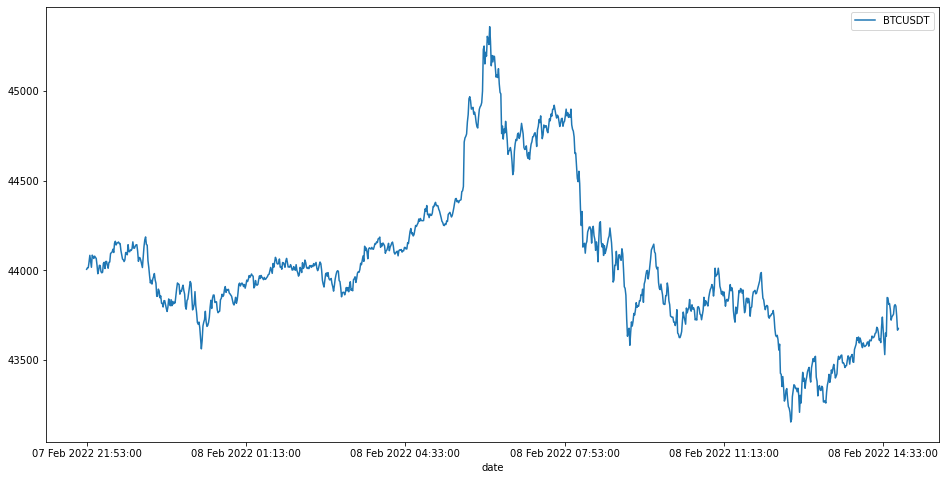

In [5]:
## Sanity checker, Are we getting the data? Let's plot it

def plotmovement(x1, y1,ticker):
    '''
    plots the noise of two coins 
    '''
    fig = plt.figure(figsize=(20,8))
    plt.plot( x1, y1,label=ticker)
    plt.legend()

## Too much data so lets just plot a subset.
    
start = 0
end = 200

fig = plt.figure(figsize=(20,8))
coindata.plot('date','BTCUSDT',figsize = (16,8),)

In [6]:
# print correlation table

coindata.corr()

,SOLUSDT,ADAUSDT,LTCUSDT,UNIUSDT,ALGOUSDT,XRPUSDT,ETHUSDT,LINKUSDT,DOTUSDT,BTCUSDT
SOLUSDT,1.000000,0.836647,0.850983,0.947962,0.974393,0.291134,0.930923,0.973132,0.969527,0.709591
ADAUSDT,0.836647,1.000000,0.884572,0.857476,0.849323,0.530374,0.805134,0.835015,0.871985,0.668961
LTCUSDT,0.850983,0.884572,1.000000,0.913259,0.854766,0.608261,0.875078,0.893421,0.892260,0.799438
UNIUSDT,0.947962,0.857476,0.913259,1.000000,0.941631,0.471629,0.946262,0.971188,0.961793,0.785530
ALGOUSDT,0.974393,0.849323,0.854766,0.941631,1.000000,0.264032,0.901733,0.968295,0.965259,0.648963
XRPUSDT,0.291134,0.530374,0.608261,0.471629,0.264032,1.000000,0.502717,0.371010,0.422747,0.743566
ETHUSDT,0.930923,0.805134,0.875078,0.946262,0.901733,0.502717,1.000000,0.937100,0.955073,0.887008
LINKUSDT,0.973132,0.835015,0.893421,0.971188,0.968295,0.371010,0.937100,1.000000,0.969397,0.737506
DOTUSDT,0.969527,0.871985,0.892260,0.961793,0.965259,0.422747,0.955073,0.969397,1.000000,0.770660
BTCUSDT,0.709591,0.668961,0.799438,0.785530,0.648963,0.743566,0.887008,0.737506,0.770660,1.000000


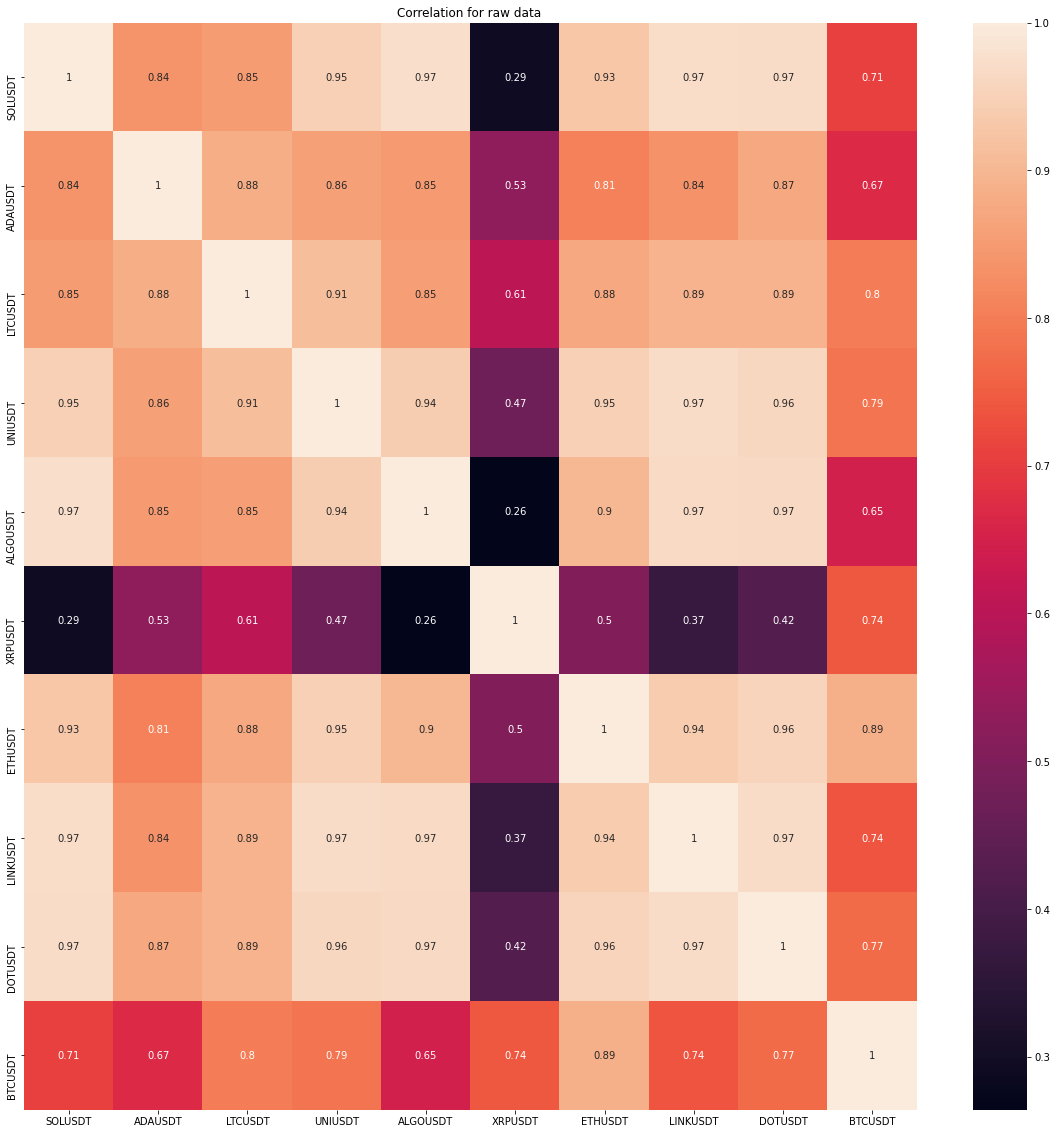

In [7]:
## Correlation matrix for raw data. 

corrMatrix = coindata.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for raw data ')
plt.show()

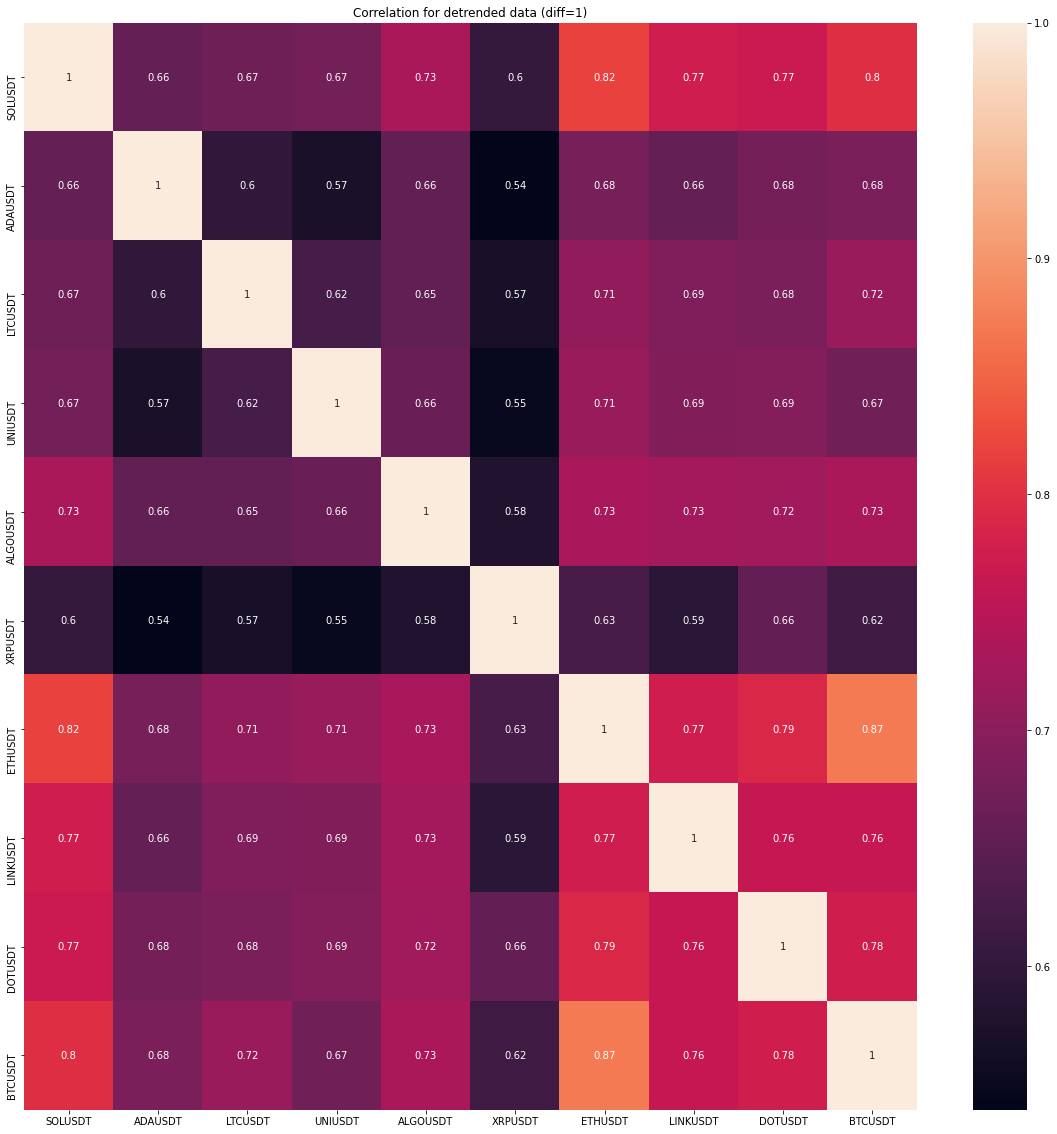

In [8]:
### Detrend the data using first difference 
### more info at https://youtu.be/nPYPyh20gGo

detrendeddata = pd.DataFrame()

for column in coindata:
    if column != 'date':
        detrendeddata[column] = coindata[column].diff(1)
        
corrMatrix = detrendeddata.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for detrended data (diff=1)')
plt.show()

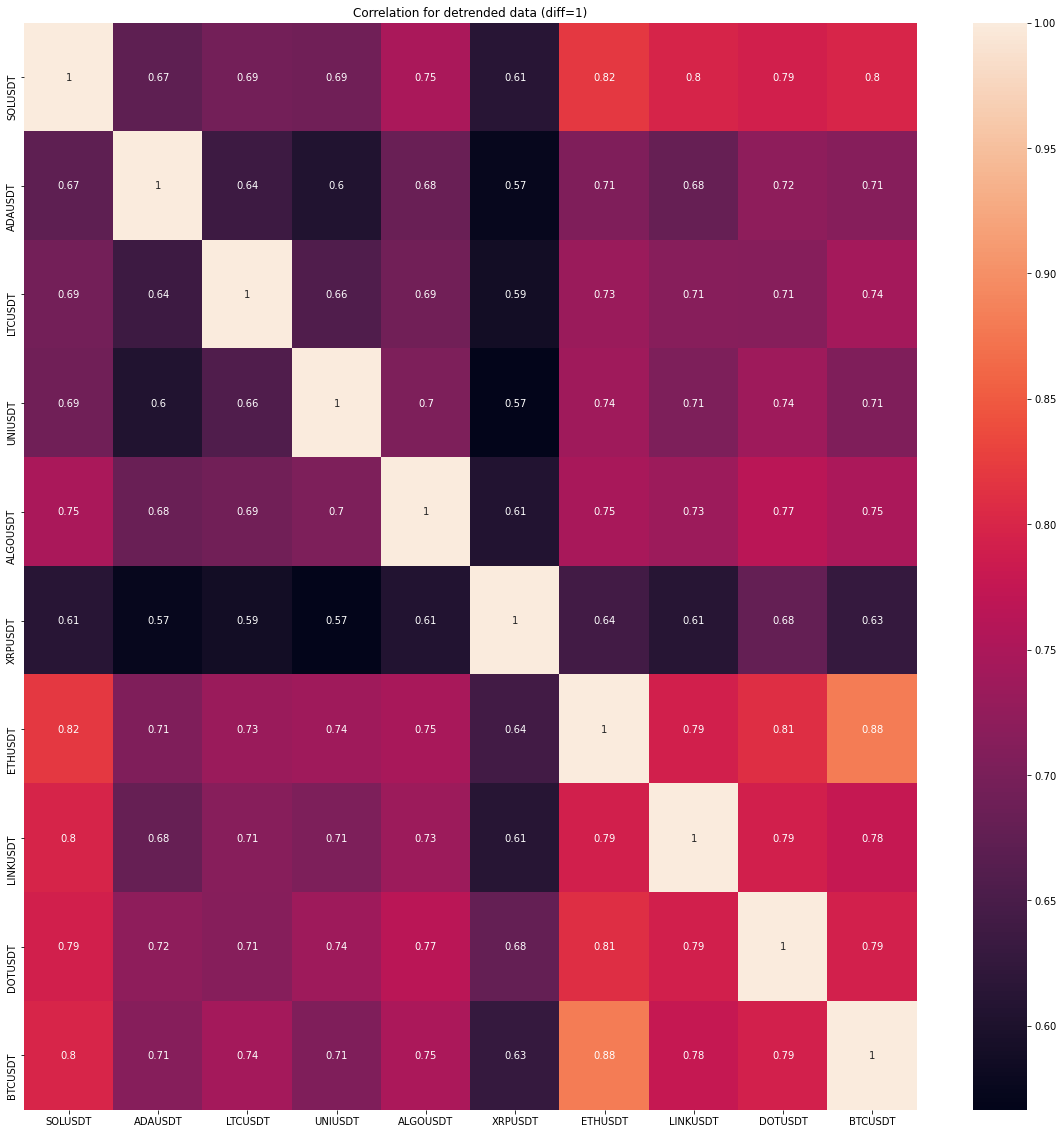

In [9]:
### Detrend the data using rolling average
radf = pd.DataFrame()

for column in coindata:
    if column != 'date':
        radf[column] = coindata[column]-coindata[column].rolling(window=3).mean()
        
corrMatrix = radf.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for detrended data (diff=1)')
plt.show()

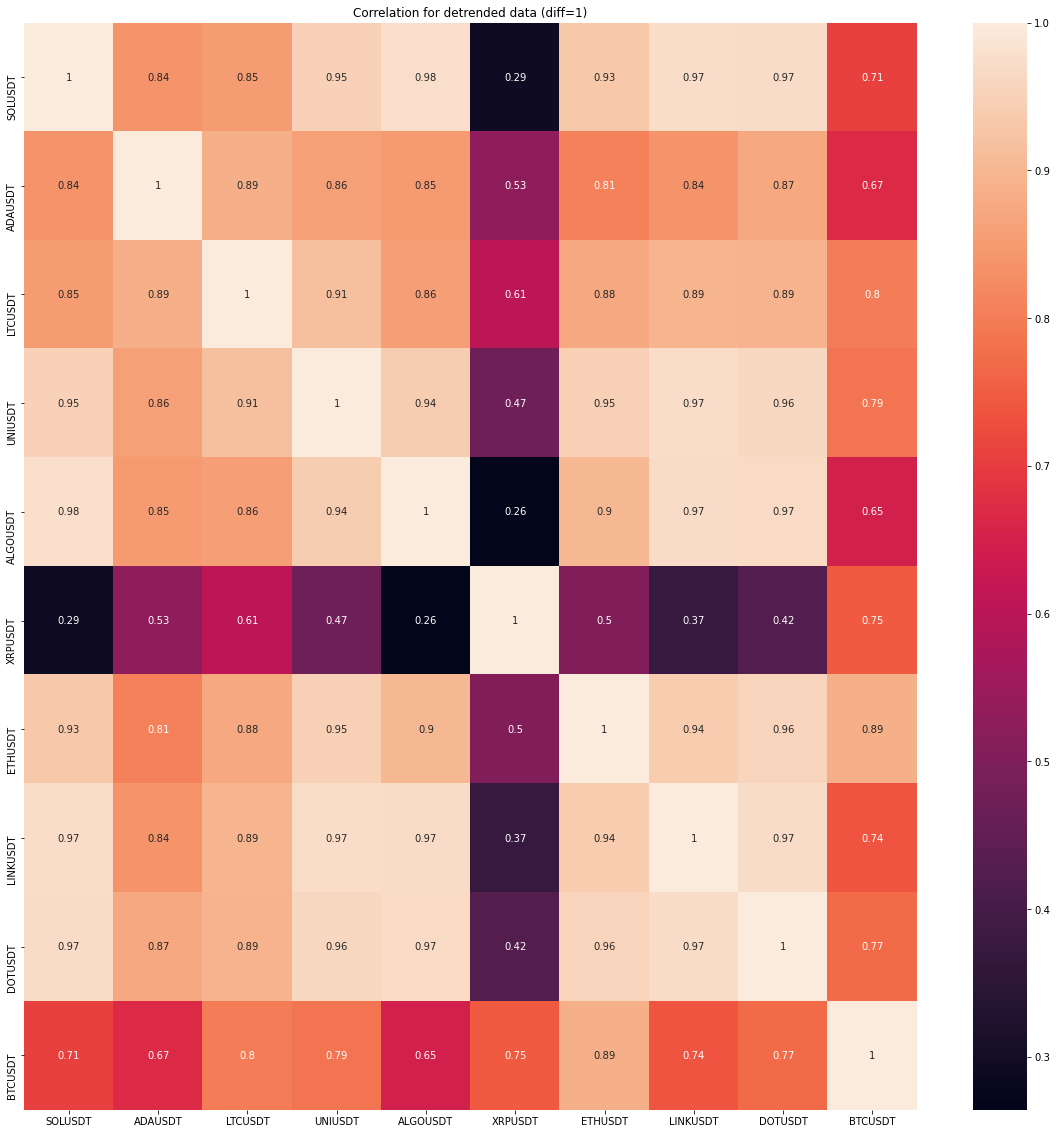

In [10]:
### Examine the trend of the rolling average

radf2 = pd.DataFrame()

for column in coindata:
    if column != 'date':
        radf2[column] = coindata[column].rolling(window=3).mean()

corrMatrix = radf2.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for detrended data (diff=1)')
plt.show()